In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../datacsv/car_fuel_efficiency.csv", delimiter=',', header=0)

In [3]:
df.sample(5)

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
7137,170,1.0,118.0,3309.951451,13.5,2022,Europe,Gasoline,All-wheel drive,-1.0,13.685757
3820,170,2.0,154.0,2795.553189,15.9,2018,Europe,Gasoline,Front-wheel drive,1.0,15.908644
3914,130,5.0,130.0,3019.801530,13.2,2021,USA,Diesel,Front-wheel drive,-1.0,15.302330
5642,250,4.0,149.0,4020.206283,15.4,2017,Europe,Gasoline,All-wheel drive,1.0,9.533227
3090,140,6.0,103.0,2522.096472,NaN,2020,Asia,Gasoline,Front-wheel drive,-1.0,17.095572


In [4]:
df = df[['engine_displacement' ,'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]

<Axes: ylabel='Frequency'>

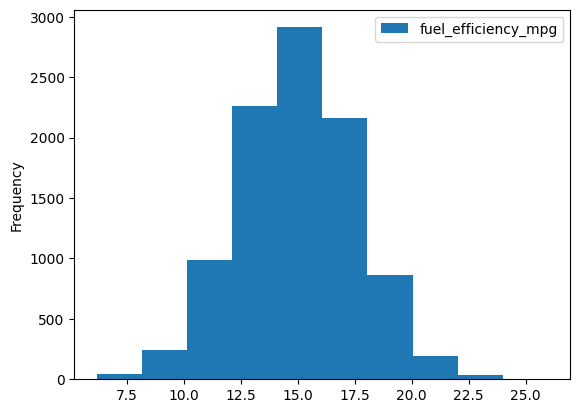

In [5]:
df.plot(kind="hist", column = "fuel_efficiency_mpg")

In [6]:
df.isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [7]:
df["horsepower"].median()

np.float64(149.0)

In [8]:
df.describe()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
count,9704.000000,8996.000000,9704.000000,9704.000000,9704.000000
mean,199.708368,149.657292,3001.280993,2011.484027,14.985243
std,49.455319,29.879555,497.894860,6.659808,2.556468
min,10.000000,37.000000,952.681761,2000.000000,6.200971
25%,170.000000,130.000000,2666.248985,2006.000000,13.267459
50%,200.000000,149.000000,2993.226296,2012.000000,15.006037
75%,230.000000,170.000000,3334.957039,2017.000000,16.707965
max,380.000000,271.000000,4739.077089,2023.000000,25.967222


In [9]:
n_train = int(0.6*len(df))
n_val = int(0.2 * len(df))
n_test = len(df) - n_train - n_val

In [10]:
np.random.seed(42)
idx = np.arange(len(df))
np.random.shuffle(idx)


df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [11]:
len(df_train) , len(df_val) , len(df_test), len(df)

(5822, 1940, 1942, 9704)

In [12]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    theta = np.linalg.inv(XTX).dot(X.T).dot(y)
    coeff = theta[1:]
    bias= theta[0]
    return coeff , bias

In [13]:
def rmse(y_pred , y):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)


In [14]:
df_filled_median = df_train.copy().fillna(df_train["horsepower"].mean())
X_median_train = df_filled_median[["engine_displacement","horsepower","vehicle_weight","model_year"]]
y_median_train = df_filled_median["fuel_efficiency_mpg"]

a , b = train_linear_regression(X_median_train, y_median_train)
a , b

(array([ 0.00012034,  0.01030286, -0.00500997, -0.00022574]),
 np.float64(28.907110618312704))

In [15]:
a.shape , b.shape

((4,), ())

In [16]:
y_val = df_val["fuel_efficiency_mpg"].values
X_val = df_val[["engine_displacement","horsepower","vehicle_weight","model_year"]].fillna(df_train["horsepower"].mean()).values
y_val_pred = X_val.dot(a) + b
print("RMSE with df filled with mean value : ", round(rmse(y_val_pred, y_val), 2))

RMSE with df filled with mean value :  0.46


In [17]:
df_filled_zeros = df_train.copy().fillna(0)
X_zeros_train = df_filled_zeros[["engine_displacement","horsepower","vehicle_weight","model_year"]]
y_zeros_train = df_filled_zeros["fuel_efficiency_mpg"]

a , b = train_linear_regression(X_zeros_train, y_zeros_train)
a , b

(array([ 9.88022381e-05,  3.54195814e-03, -5.01316573e-03,  3.51135283e-04]),
 np.float64(28.8107493318962))

In [18]:
y_val = df_val["fuel_efficiency_mpg"].values
X_val_zeros = df_val[["engine_displacement","horsepower","vehicle_weight","model_year"]].fillna(0).values
y_val_pred = X_val_zeros.dot(a) + b
print("RMSE with df filled with zeros : ", round(rmse(y_val_pred, y_val), 2))

RMSE with df filled with zeros :  0.52


In [19]:
def ridge_regression(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    theta = np.linalg.inv(XTX + r * np.eye(XTX.shape[0])).dot(X.T).dot(y)
    coeff = theta[1:]
    bias= theta[0]
    return coeff , bias

In [20]:
r = [0, 0.01, 0.1, 1, 5, 10, 100]
X_val_zeros = df_val[["engine_displacement","horsepower","vehicle_weight","model_year"]].fillna(0).values
X_zeros_train = df_filled_zeros[["engine_displacement","horsepower","vehicle_weight","model_year"]]
y_zeros_train = df_filled_zeros["fuel_efficiency_mpg"]
for pen in r :
    a, b = ridge_regression(X_zeros_train.values, y_zeros_train.values, pen)
    y_val_pred = X_val_zeros.dot(a) + b
    print(f"RMSE for penality : {pen} = {rmse(y_val_pred, y_val)}")
    

RMSE for penality : 0 = 0.5171866956569342
RMSE for penality : 0.01 = 0.5169342809307013
RMSE for penality : 0.1 = 0.518626929018817
RMSE for penality : 1 = 0.5221435511942384
RMSE for penality : 5 = 0.5228049144164512
RMSE for penality : 10 = 0.5228952084992662
RMSE for penality : 100 = 0.522978084800772


In [22]:
seed_values = np.arange(10)
seed_values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [25]:
rmse_scores = np.array([])
for seed_val in seed_values :
    np.random.seed(seed_val)
    i = np.arange(len(df))
    np.random.shuffle(i)
    data = df.copy().fillna(0)
    df_train = data.iloc[i[:n_train]]
    df_val = data.iloc[i[n_train:n_train+n_val]]
    df_test = data.iloc[i[n_train+n_val:]]
    X_train = df_train[["engine_displacement","horsepower","vehicle_weight","model_year"]]
    y_train = df_train["fuel_efficiency_mpg"].values
    a , b = train_linear_regression(X_train , y_train)
    X_val = df_val[["engine_displacement","horsepower","vehicle_weight","model_year"]].values
    y_val = df_val["fuel_efficiency_mpg"].values
    y_pred = X_val.dot(a) + b
    rmse_scores = np.append(rmse_scores,round(rmse(y_pred , y_val), 3))

print("Standard deviation of rmse scores is : ", rmse_scores.std())
    

Standard deviation of rmse scores is :  0.007096477999684075


In [35]:
np.random.seed(9)
idx = np.arange(len(df))
np.random.shuffle(idx)
data = df.copy().fillna(0)


df_train = data.iloc[idx[:n_train]]
df_val = data.iloc[idx[n_train:n_train+n_val]]
df_test = data.iloc[idx[n_train+n_val:]]

df_train_all = pd.concat([df_train,df_val]).reset_index(drop=True)
X_train_all = df_train_all[["engine_displacement","horsepower","vehicle_weight","model_year"]].values
y_train_all = df_train_all["fuel_efficiency_mpg"].values


a ,b = ridge_regression(X_train_all, y_train_all, 0.001)

X_test = df_test[["engine_displacement","horsepower","vehicle_weight","model_year"]].values
y_test = df_test["fuel_efficiency_mpg"]

y_pred = X_test.dot(a) + b
print("RMSE for test dataset is : ", rmse(y_pred ,y_test)) 

RMSE for test dataset is :  0.5155043369325081
